## ​ODAY ​NAJAD (Matricola N. 2107495)

# Evaluating Robustness of Deep Belief Networks and Feedforward Neural Networks Against Noise and Adversarial Attacks

### **Introduction:**

Robustness is a fundamental aspect of machine learning models, especially in domains where reliability and security are paramount. In this project, we delve into the evaluation of two prominent neural network architectures, namely Deep Belief Networks (DBNs) and Feedforward Neural Networks (FFNNs), to understand their robustness against two common types of perturbations: noise and adversarial attacks.

Deep Belief Networks are probabilistic generative models composed of multiple layers of Restricted Boltzmann Machines (RBMs). They are known for their ability to capture intricate patterns and dependencies in data through unsupervised learning. On the other hand, Feedforward Neural Networks are conventional architectures consisting of interconnected layers of neurons, typically used for supervised learning tasks such as classification and regression.

The primary objective of this project is to investigate how DBNs and FFNNs respond to noise, which can occur due to various factors such as sensor imperfections, data transmission errors, or environmental interference. We simulate noise by injecting random perturbations into the input data and analyze the models' classification performance under different noise levels. Understanding how these models degrade in the presence of noise is crucial for deploying them in real-world applications where data quality may vary.

Additionally, we examine the robustness of DBNs and FFNNs against adversarial attacks, particularly focusing on the Fast Gradient Sign Method (FGSM). Adversarial attacks aim to exploit vulnerabilities in neural networks by introducing carefully crafted perturbations to input data, leading to misclassification. By subjecting the models to adversarial attacks, we assess their susceptibility and explore strategies to enhance their resilience against such attacks.

Through comprehensive experimentation and analysis, we aim to provide insights into the comparative robustness of DBNs and FFNNs against noise and adversarial attacks. This knowledge is essential for developing more robust and trustworthy machine learning systems that can withstand real-world challenges and adversities.

### Setting up the environment:
This function retrieves the necessary files for the Deep Belief Network (DBN) implementation from a GitHub repository. It downloads the files "DBN.py" and "RBM.py" using the `wget` command from the specified repository URL. This ensures that the required code files are available locally for later use in the project.

In [1]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [2]:
%%capture
get_dbn_library()

The required libraries and modules have been successfully imported. These include:
- `matplotlib.pyplot` for data visualization.
- `math` for mathematical operations.
- `numpy` as `np` for numerical computing.
- `pandas` as `pd` for data manipulation and analysis.
- `scipy.cluster` for clustering algorithms.
- `sklearn.preprocessing` for data preprocessing.
- `torch` for building and training neural networks.
- `torchvision` as `tv` for computer vision tasks.
- `DBN` module, which presumably contains the Deep Belief Network implementation.


In [21]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

The code checks if a CUDA-enabled GPU is available for computation. It then sets the device to CUDA if a GPU is available; otherwise, it sets the device to CPU. Let's see the output:

In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

False
cpu


So we are going to work using our CPU...

### Importing and Data Munging

Here, a transform is defined to convert images to tensors and normalize them. The `Compose` function combines multiple transformations into a single transformation pipeline. The transformations applied are:
- `ToTensor()`: Converts the image to a tensor.
- `Normalize((0.5,), (0.5,),)`: Normalizes the tensor image with mean 0.5 and standard deviation 0.5 along all channels.

Next, the FashionMNIST dataset is loaded, consisting of both training and testing sets. The `FashionMNIST` class from `torchvision.datasets` is used for this purpose. The training set is downloaded and transformed using the specified transform, while the testing set is downloaded and transformed similarly. The datasets are stored in `trainset` and `testset`, respectively.


In [20]:
%%capture
#Define a transform to convert to images to tensor and normalize
transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                               tv.transforms.Normalize((0.5,),(0.5,),)]) #mean and std have to be sequences (e.g., tuples), 
                                                                      # therefore we should add a comma after the values
                          
#Load the data: train and test sets
trainset = tv.datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
testset = tv.datasets.FashionMNIST('./data', download=True, train=False, transform=transform)


The pixel values of the training and testing datasets are normalized by dividing each pixel value by 255 and then converting the data type to `torch.FloatTensor`. This operation ensures that the pixel values are within the range [0, 1].

In [22]:
trainset.data = (trainset.data.type(torch.FloatTensor)/255)
testset.data = (testset.data.type(torch.FloatTensor)/255)

This code displays an image from the training dataset at index `idx`. It prints the label associated with the image, indicating the category it belongs to. Finally, it visualizes the image using matplotlib's `imshow()` function with a grayscale colormap.


The number shown is the number: 2


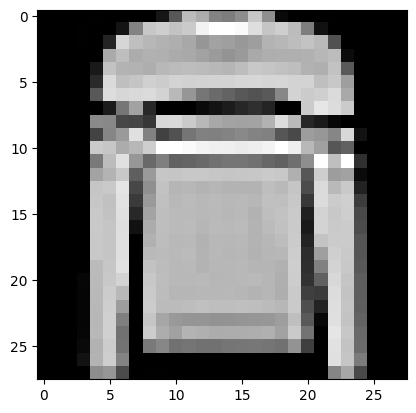

In [23]:
idx = 5
img = trainset.data[idx]
print("The number shown is the number: {}".format(trainset.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

The training and testing datasets are moved to the specified device (`cuda` if available, otherwise `cpu`). This operation ensures that the data is processed on the appropriate device for computation, whether it's a GPU or CPU.

In [24]:
trainset.data = trainset.data.to(device)
testset.data = testset.data.to(device)

The labels of the training and testing datasets are moved to the specified device (`cuda` if available, otherwise `cpu`). This operation ensures that the labels are processed on the same device as the corresponding data, facilitating compatibility for further computations.

In [25]:
trainset.targets = trainset.targets.to(device)
testset.targets = testset.targets.to(device)

## Training a DBN

A Deep Belief Network is constructed from a series of Restricted Boltzmann Machines, which belong to the family of energy-based models. These networks are categorized as unsupervised deep learning architectures with the primary objective of grasping the underlying probability distribution that generated the training data, a process known as maximum-likelihood estimation. Consequently, they are adept at conducting both forward (bottom-up) and backward (top-down) passes through the architecture. These passes facilitate tasks such as computing hidden representations (inference over latent variables) or generating prototypical examples of a specific class. Their training involves the utilization of an algorithm named contrastive divergence, tailored to minimize the dissimilarity between the learned probability distribution and the true empirical distribution of the data.

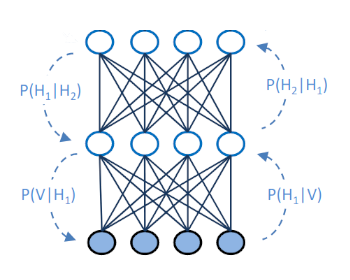

A Deep Belief Network (DBN) is instantiated with the following parameters:
- `visible_units`: Number of units in the visible layer, which is set to 28x28 for Fashion MNIST dataset.
- `hidden_units`: List of integers representing the number of units in each hidden layer. In this case, there are three hidden layers with 400, 500, and 800 units respectively.
- `k`: Number of Contrastive Divergence (CD) steps used during training, set to 1.
- `learning_rate`: The learning rate for training the network, set to 0.1.
- `learning_rate_decay`: Whether to apply learning rate decay during training, set to False.
- `initial_momentum`: The initial momentum for training, set to 0.5.
- `final_momentum`: The final momentum for training, set to 0.95.
- `weight_decay`: The weight decay coefficient for regularization, set to 0.0001.
- `xavier_init`: Whether to initialize the weights using Xavier initialization, set to False.
- `increase_to_cd_k`: Whether to increase the number of CD steps during training, set to False.
- `use_gpu`: Whether to utilize GPU for computation, determined by the availability of CUDA-enabled GPU using `torch.cuda.is_available()`.


In [26]:
dbn_f_mnist = DBN(visible_units=28*28,
                hidden_units=[400, 500, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Training the network:

The Deep Belief Network (DBN) `dbn_f_mnist` is trained using the `train_static` method with the following parameters:
- `trainset.data`: The input data from the training set.
- `trainset.targets`: The corresponding labels from the training set.
- `num_epochs`: The number of training epochs, set to 50.
- `batch_size`: The batch size used during training, set to 125.


In [27]:
num_epochs = 50
batch_size = 125

dbn_f_mnist.train_static(
    trainset.data,
    trainset.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8716     |0.0836       |314.8945   |6.4636     |
|20    |1.7469     |0.0789       |297.9238   |5.4763     |
|30    |1.7119     |0.0773       |291.5600   |5.4614     |
|40    |1.7020     |0.0777       |291.5554   |5.9993     |
|50    |1.6924     |0.0750       |288.2911   |4.9271     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0769     |0.0372       |140.5174   |2.5011     |
|20    |1.0019     |0.0328       |131.2976   |2.3775     |
|30    |0.9827     |0.0324       |127.3155   |2.4425     |
|40    |0.9714     |0.0318       |125.6381   |1.9559     |
|50    |0.9634     |0.0322       |124.2608   |2.0508     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.8410     |0.0278       |147.7840   |2.1263     |
|20    |0.7395     |0.0242       |135.7242   |2.156

The training progress of each Restricted Boltzmann Machine (RBM) layer within the Deep Belief Network (DBN) is summarized below:

- **Training RBM layer 1:**
  - The reconstruction error decreases gradually over epochs, indicating improvement in learning.
  - The mean and standard deviation of gradients show a decreasing trend, indicating convergence of the optimization process.

- **Training RBM layer 2:**
  - Similar to the first layer, the reconstruction error decreases consistently over epochs, indicating continued improvement.
  - The mean and standard deviation of gradients also decrease, suggesting convergence and stability in training.

- **Training RBM layer 3:**
  - The reconstruction error continues to decrease over epochs, demonstrating further improvement in learning.
  - The mean and standard deviation of gradients exhibit a decreasing trend, indicating convergence and stability in optimization.

Overall, the training process for all RBM layers shows a consistent decrease in reconstruction error and a convergence of gradients, suggesting effective learning and optimization within the DBN architecture.


## Visualizing receptive fields


After completing the network training phase, we'll proceed to visualize the learned weights. To achieve this, we'll generate plots representing a selection of weights in images of the same dimensions as the Fashion MNIST dataset images used during training. This visualization will help us discern which parts of an image activate the unit associated with a specific weight vector.

To enhance the clarity of the plots and reduce noise, we'll apply a threshold to the learned weights. Additionally, since the weights may vary in range, we'll utilize the `MinMaxScaler` from Scikit-Learn to ensure meaningful comparisons across different receptive fields visualizations.

The following functions are defined for post-training analysis and visualization of learned weights:

- `get_weights(dbn, layer)`: Retrieves the weights of a specific layer from the trained Deep Belief Network (DBN) and converts them to a NumPy array on the CPU.
- `apply_threshold(weights, threshold=0)`: Applies a threshold to the weights, setting values below the threshold to zero.
- `plot_layer_receptive_fields(weights)`: Plots the receptive fields of a layer by visualizing a selection of weights as images. The number of subplots is set to 100, with the images arranged in a square grid.
- `apply_min_max_scaler(learned_weights)`: Applies min-max scaling to the learned weights to ensure consistent ranges for meaningful visual comparison.


In [28]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights  

The learned weights of the first layer are obtained from the trained Deep Belief Network (DBN), and a threshold of 0.1 is applied to them. Subsequently, min-max scaling is applied to ensure consistent ranges for meaningful visual comparison. Finally, the receptive fields of the first layer are plotted using the `plot_layer_receptive_fields()` function.

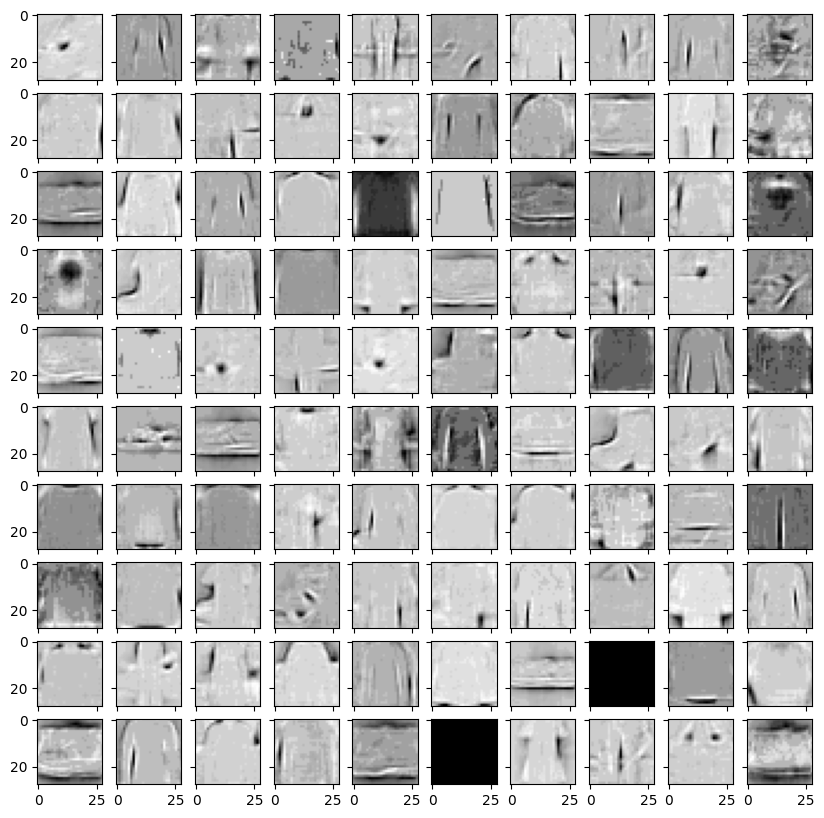

In [29]:
learned_weights_layer_1 = get_weights(dbn_f_mnist, layer=0)
learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_1 = apply_min_max_scaler(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)

The learned weights of the first and second layers are retrieved from the trained Deep Belief Network (DBN). A threshold of 0.1 is applied to both sets of weights to reduce noise. 

Next, the product of the learned weights of the two layers is computed, representing the projection of the receptive fields. Another threshold of 0.1 is applied to the resulting weights, followed by min-max scaling to ensure consistent ranges for meaningful visual comparison.

Finally, the receptive fields resulting from the projection are plotted using the `plot_layer_receptive_fields()` function.


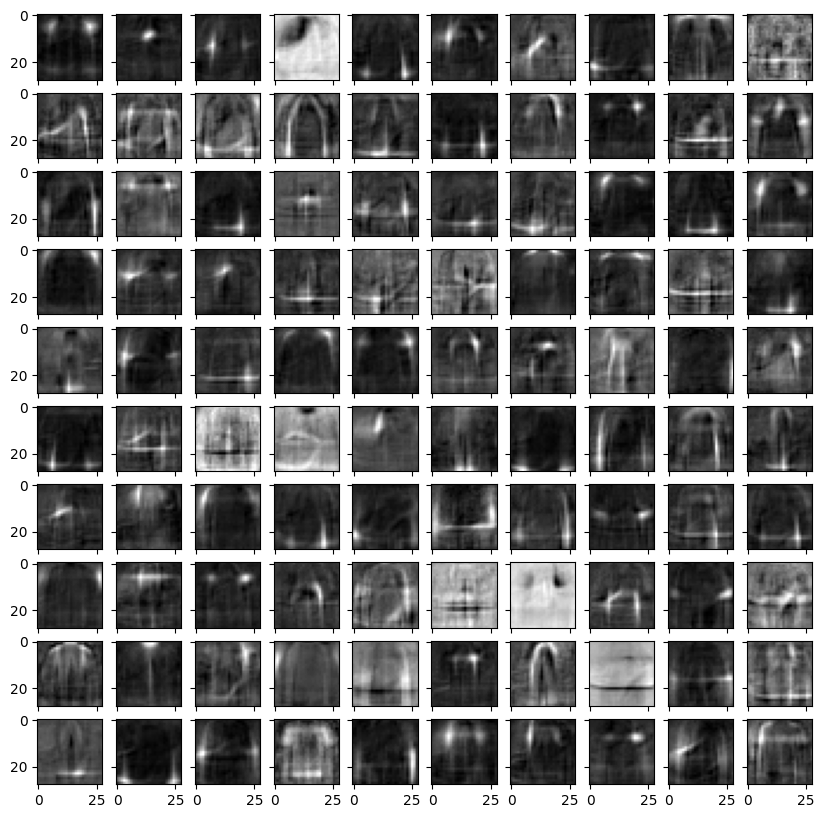

In [31]:
learned_weights_layer_1 = get_weights(dbn_f_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_f_mnist, layer=1)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)

learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_product = apply_threshold(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaler(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

The learned weights of the first, second, and third layers are retrieved from the trained Deep Belief Network (DBN). A threshold of 0.1 is applied to each set of weights to reduce noise.

Subsequently, the product of the learned weights between the first and second layers is computed to obtain a projection. Then, this projection is multiplied with the learned weights of the third layer to obtain another projection. Thresholding is applied to the resulting weights, followed by min-max scaling to ensure consistent ranges for meaningful visual comparison.

Finally, the receptive fields resulting from the last projection are plotted using the `plot_layer_receptive_fields()` function.


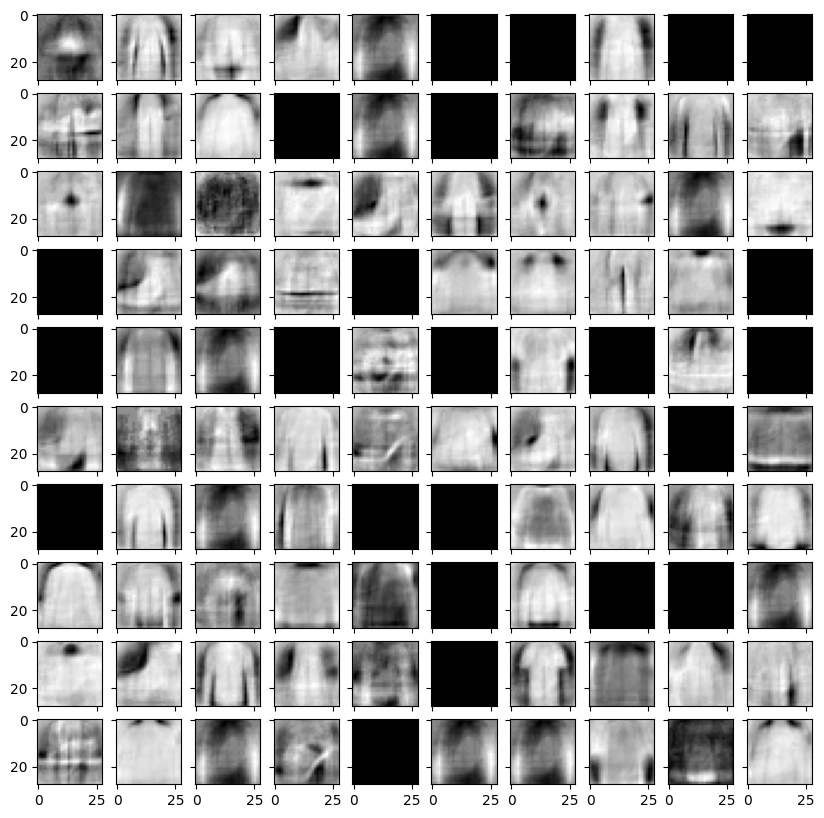

In [33]:
learned_weights_layer_1 = get_weights(dbn_f_mnist, layer=0)
learned_weights_layer_2 = get_weights(dbn_f_mnist, layer=1)
learned_weights_layer_3 = get_weights(dbn_f_mnist, layer=2)

learned_weights_layer_1 = apply_threshold(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold(learned_weights_layer_2, 0.1)
learned_weights_layer_3 = apply_threshold(learned_weights_layer_3, 0.1)

learned_weights_12_product = (learned_weights_layer_1 @ learned_weights_layer_2)  # here we do the projection
learned_weights_23_product = (learned_weights_12_product @ learned_weights_layer_3)  # here we do the projection
learned_weights_23_product = apply_threshold(learned_weights_23_product, 0.1)
learned_weights_23_product = apply_min_max_scaler(learned_weights_23_product)

plot_layer_receptive_fields(learned_weights_23_product.T)

## Analyzing Internal Representations through Clustering

Next, our objective is to investigate the characteristics of the learned representations. To accomplish this, we will calculate the centroid of the representations learned for each class and assess their proximity to each other using a standard hierarchical clustering algorithm.

Since this implementation of the `Deep Belief Network (DBN)` includes multiple `RBM` objects internally, we'll need to compute the hidden representation using the weights of each `RBM` within the `DBN`.

The function `get_kth_layer_repr(input, k, device)` is defined to obtain the hidden representations of the input data at the k-th layer of the Deep Belief Network (DBN). Here's how it works:
- `input`: The input data, which is flattened and converted to a float tensor of shape `(batch_size, flattened_input_size)` to match the input format expected by the DBN.
- `k`: The index of the layer for which hidden representations are to be computed.
- `device`: Specifies the device (CPU or GPU) on which the computations should be performed.

The function computes the hidden representations using the weights of the RBM object associated with the k-th layer of the DBN. The resulting hidden representations are returned.


In [36]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_f_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

The hidden representations for each layer of the Deep Belief Network (DBN) are computed as follows:
- `hidden_repr_layer_1`: The hidden representations for the first layer are obtained by passing the input data from the training set through the DBN's first layer.
- `hidden_repr_layer_2`: The hidden representations for the second layer are computed using the hidden representations from the first layer.
- `hidden_repr_layer_3`: Similarly, the hidden representations for the third layer are computed using the hidden representations from the second layer.

These hidden representations capture the learned features at each layer of the DBN.


In [37]:
hidden_repr_layer_1 = get_kth_layer_repr(trainset.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

The following functions are defined for analyzing hidden representations:

- `get_mask(label)`: Filters the data by class label to isolate instances of a specific class.
- `get_label_to_mean_hidd_repr(hidden_representation)`: Computes the mean hidden representation for each class based on the provided hidden representations. It returns a dictionary where each class label maps to its corresponding mean hidden representation.
- `get_hidden_reprs_matrix(hidden_representation)`: Constructs matrices of mean hidden representations for each class. It concatenates the mean hidden representations for all classes along the first axis to form a single matrix.

Finally, the `mean_hidd_repr_matrix_3` variable contains the matrix of mean hidden representations for the third layer of the Deep Belief Network (DBN).


In [38]:
def get_mask(label):  # we use this function to filter by class
  labels = trainset.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [39]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

The `plot_dendrogram(mean_repr_matrix, title="")` function is utilized to visualize dendrograms of hierarchical clustering.

- `mean_repr_matrix`: The matrix of mean hidden representations for each class.
- `title`: Optional parameter specifying the title of the dendrogram plot.

Within the function:
- The hierarchical clustering algorithm is executed using the `complete` linkage method.
- The resulting dendrogram is plotted.

The provided code plots a dendrogram for the third hidden layer's mean hidden representations.


In [40]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

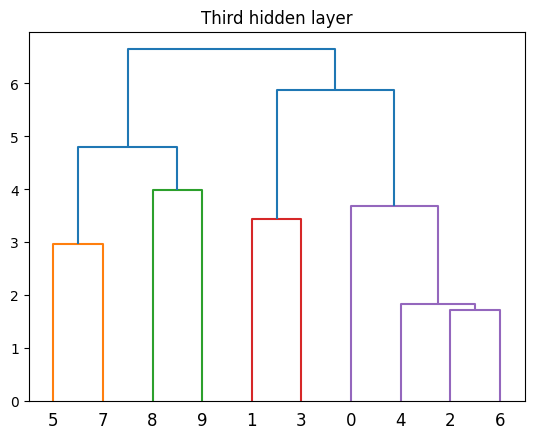

In [41]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out

Next, we perform a linear readout of the representations generated by the Deep Belief Network (DBN) at each layer. This involves utilizing the representations to classify the original images using a basic linear classifier. This approach allows us to evaluate the amount of information contained within each hidden representation.
The `LinearModel` class is designed as a simple linear classifier. Here's the logic behind the code:

- **Initialization (`__init__` method):**
  - Inherits from `torch.nn.Module`.
  - Initializes a linear layer (`self.linear`) with input size `layer_size` and output size 10, corresponding to the number of classes in the Fashion MNIST dataset.

- **Forward Pass (`forward` method):**
  - Defines the forward pass of the model.
  - Takes input `x` and passes it through the linear layer (`self.linear`).
  - Returns the output of the linear layer, which represents the logits for each class.

This class encapsulates the functionality of a linear classifier, making it straightforward to implement and utilize in classification tasks.


In [42]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Three instances of the `LinearModel` class are created, each corresponding to a layer of the Deep Belief Network (DBN). Here's the logic behind the code:

- For each layer of the DBN:
  - The size of the layer is determined by accessing the shape of the weights (`W`) of the corresponding RBM layer within the DBN (`dbn_f_mnist.rbm_layers[i].W.shape[1]`), which represents the number of hidden units in that layer.
  - A linear model (`LinearModel`) is instantiated with the determined layer size.
  - The linear model is moved to the specified device (CPU or GPU) using `.to(device)`.

These linear models will be used for performing linear classification tasks based on the representations learned by each layer of the DBN.


In [44]:
layer_size = dbn_f_mnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_f_mnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_f_mnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

The `train` function is defined to train a given neural network model (`network`) using the provided input data. Here's the logic behind the code:

- **Initialization:**
  - Determines the printing stride (`print_stride`) based on the number of epochs. If the number of epochs is greater than or equal to 1000, the printing stride is set to 100; otherwise, it's set to 10.
  - Initializes the optimizer using stochastic gradient descent (`torch.optim.SGD`) with a learning rate of 0.05.
  - Defines the loss function as cross-entropy loss (`torch.nn.CrossEntropyLoss()`).
  - Retrieves the targets (labels) from the training dataset.

- **Training Loop:**
  - Iterates over the specified number of epochs.
  - Resets the gradients of the optimizer (`optimizer.zero_grad()`).
  - Computes predictions using the input data (`input`) and the neural network (`network`).
  - Calculates the loss between the predictions and the targets.
  - Backpropagates the loss to update the network parameters (`loss.backward()` and `optimizer.step()`).
  - Prints the epoch number and loss every `print_stride` epochs for tracking the training progress.

This function facilitates the training of a neural network model by automatically handling the optimization process and providing feedback on the training progress.


In [64]:
def train(network, input, epochs=1000):
  print_stride = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  targets = trainset.targets

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input)
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % print_stride == 0:
      print("epoch: {:4d}/{} | loss: {:.3f}".format(epoch, epochs, loss))
  print()

The `train` function is called to train the linear classifier `linear1`, `linear2` and `linear2` using the hidden representations from the first, second and third layers of the Deep Belief Network (DBN). This process involves optimizing the parameters of the linear model to minimize the cross-entropy loss between the predicted class probabilities and the true labels from the training dataset. Training progress, including the epoch number and loss, is printed periodically to track the training process.

In [65]:
train(linear1, hidden_repr_layer_1)

epoch:    0/1000 | loss: 0.409
epoch:  100/1000 | loss: 0.407
epoch:  200/1000 | loss: 0.405
epoch:  300/1000 | loss: 0.403
epoch:  400/1000 | loss: 0.402
epoch:  500/1000 | loss: 0.400
epoch:  600/1000 | loss: 0.399
epoch:  700/1000 | loss: 0.397
epoch:  800/1000 | loss: 0.396
epoch:  900/1000 | loss: 0.394



In [66]:
train(linear2, hidden_repr_layer_2)

epoch:    0/1000 | loss: 0.438
epoch:  100/1000 | loss: 0.433
epoch:  200/1000 | loss: 0.430
epoch:  300/1000 | loss: 0.426
epoch:  400/1000 | loss: 0.423
epoch:  500/1000 | loss: 0.420
epoch:  600/1000 | loss: 0.418
epoch:  700/1000 | loss: 0.415
epoch:  800/1000 | loss: 0.413
epoch:  900/1000 | loss: 0.411



In [67]:
train(linear3, hidden_repr_layer_3)

epoch:    0/1000 | loss: 0.443
epoch:  100/1000 | loss: 0.438
epoch:  200/1000 | loss: 0.435
epoch:  300/1000 | loss: 0.431
epoch:  400/1000 | loss: 0.428
epoch:  500/1000 | loss: 0.425
epoch:  600/1000 | loss: 0.422
epoch:  700/1000 | loss: 0.420
epoch:  800/1000 | loss: 0.417
epoch:  900/1000 | loss: 0.415



Now, we'll construct representations for the test set that was initially set aside, and utilize them to assess the performance of the trained linear classifiers.

Hidden representations for the test set are generated as follows:
- `hidden_repr_layer_1_test`: Hidden representations for the first layer are obtained by passing the test set data through the first layer of the Deep Belief Network (DBN).
- `hidden_repr_layer_2_test`: Hidden representations for the second layer are computed using the hidden representations from the first layer.
- `hidden_repr_layer_3_test`: Similarly, the hidden representations for the third layer are computed using the hidden representations from the second layer.


In [68]:
hidden_repr_layer_1_test = get_kth_layer_repr(testset.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In the following lines of code, predictions are computed using the trained linear classifiers for each layer of the Deep Belief Network (DBN) on the test set:

- `predictions_test1`: Predictions are computed using the linear classifier `linear1` on the hidden representations from the first layer (`hidden_repr_layer_1_test`).
- `predictions_test2`: Predictions are computed using the linear classifier `linear2` on the hidden representations from the second layer (`hidden_repr_layer_2_test`).
- `predictions_test3`: Predictions are computed using the linear classifier `linear3` on the hidden representations from the third layer (`hidden_repr_layer_3_test`).


In [69]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

Let's compute the accuracy scores:

The `compute_accuracy` function is utilized to calculate the accuracy of the predictions on the test set compared to the true labels. Here's how it works:

- **Input Parameters:**
  - `predictions_test`: Predictions made by the model on the test set.
  - `targets`: True labels of the test set.

- **Functionality:**
  - Converts the predicted probabilities to indices representing the predicted classes using `.max(axis=1).indices`.
  - Compares the predicted indices with the true labels and calculates the accuracy as the ratio of correct predictions to the total number of samples in the test set.
  - Returns the accuracy as a floating-point number.

The accuracy of the predictions made by each linear classifier (`predictions_test1`, `predictions_test2`, `predictions_test3`) on the test set is computed using this function.


In [70]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [71]:
compute_accuracy(predictions_test1, testset.targets)

0.8510000109672546

In [72]:
compute_accuracy(predictions_test2, testset.targets)

0.8485999703407288

In [73]:
compute_accuracy(predictions_test3, testset.targets)

0.8463000059127808

## Comparison with a feed-forward model

Next, we'll train a basic feed-forward neural network with a structure identical to the Deep Belief Network (DBN). This comparison aims to contrast a nonlinear model trained end-to-end for a classification task with a simple linear classifier that utilizes representations of input data learned in an unsupervised manner.

The `Feedforward` class defines a simple feed-forward neural network with three hidden layers. Here's how it works:

- **Initialization (`__init__` method):**
  - Sets up the neural network structure with three linear layers followed by ReLU activation functions.
  - The sizes of the hidden layers are determined by the input parameters.
  - The input size of the first layer is 784, representing the flattened size of the Fashion MNIST images.
  - The output size of the final layer is 10, corresponding to the number of classes in the dataset.

- **Forward Pass (`forward` method):**
  - Executes the forward pass of the neural network.
  - Applies the ReLU activation function to the output of each linear layer.
  - Propagates the input through each layer sequentially, transforming it into higher-level representations.
  - Returns the output of the final layer, which provides class scores for each input sample.

This class serves as a foundation for training a feed-forward neural network to perform classification tasks.


In [74]:
class Feedforward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [75]:
ffnn = Feedforward(400, 500, 800).to(device)

We choose the number of epochs to match the training time of the DBN and the readout layer combined.

In [76]:
train(ffnn, trainset.data.reshape((60000, 784)), epochs=1500)

epoch:    0/1500 | loss: 2.305
epoch:  100/1500 | loss: 1.440
epoch:  200/1500 | loss: 0.916
epoch:  300/1500 | loss: 0.761
epoch:  400/1500 | loss: 0.674
epoch:  500/1500 | loss: 0.618
epoch:  600/1500 | loss: 0.580
epoch:  700/1500 | loss: 0.555
epoch:  800/1500 | loss: 0.516
epoch:  900/1500 | loss: 0.520
epoch: 1000/1500 | loss: 0.480
epoch: 1100/1500 | loss: 0.467
epoch: 1200/1500 | loss: 0.453
epoch: 1300/1500 | loss: 0.443
epoch: 1400/1500 | loss: 0.440



In [79]:
predictions_ffnn = ffnn(testset.data.reshape((10000, 784)))

In [80]:
compute_accuracy(predictions_ffnn, testset.targets)

0.8292999863624573

### Confusion Matrix

DBN with Read-out Confusion Matrix


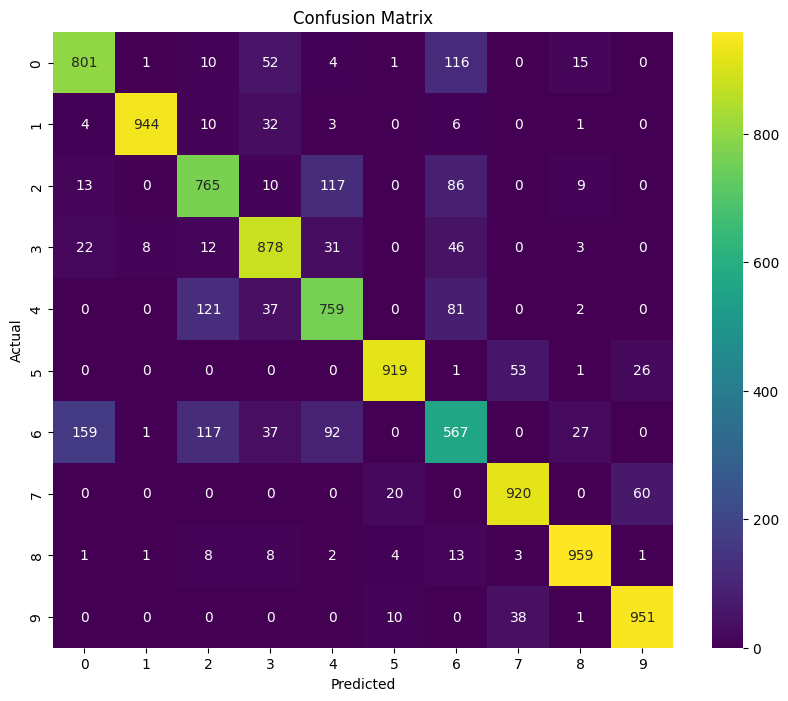

FFNN Confusion Matrix


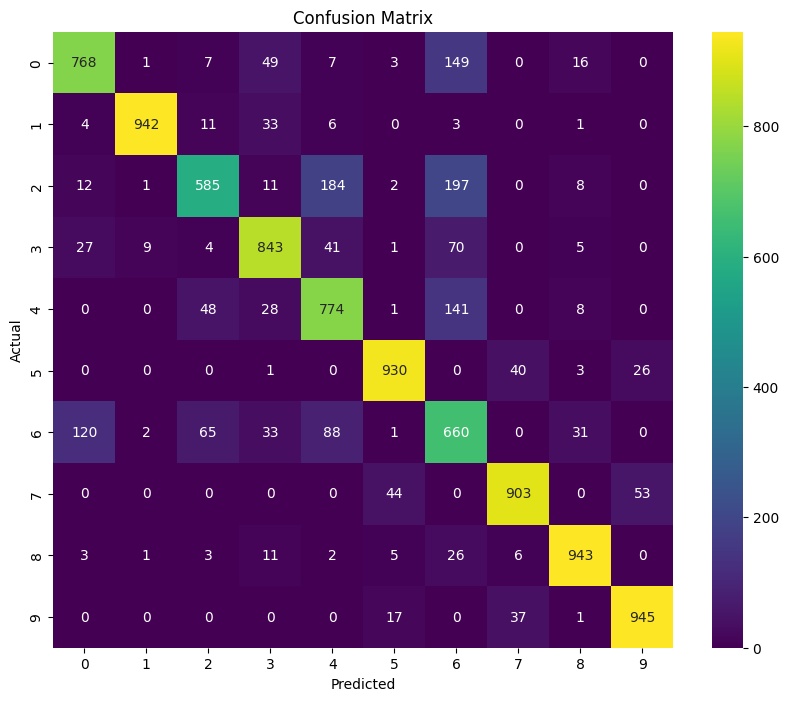

In [124]:
def plot_confusion_matrix(model, device, test_loader):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28 * 28)  # Flatten the input data to match the input size of the feedforward network
            output = model(data)
            predictions = output.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

print("DBN with Read-out Confusion Matrix")
plot_confusion_matrix(dbn_with_readout, device, test_loader)  
print("FFNN Confusion Matrix")
plot_confusion_matrix(ffnn, device, test_loader)  


## Testing Robustness to Noise

Next, we'll introduce noise into the input images to assess the resilience of the learned representations by both the DBN and the feed-forward network against disturbances in the sensory signal.

Similar to psychophysical experiments, this will enable the creation of a psychometric curve illustrating the decline in classification accuracy as a function of the noise level.

The `inject_noise` function is defined to introduce noise into Fashion MNIST data:

- **Input Parameters:**
  - `f_mnist_data`: Fashion MNIST data (input images).
  - `noise_level`: Magnitude of the noise to be injected.

- **Functionality:**
  - Generates a random Gaussian tensor with the same shape as the input data, scaled by the specified noise level.
  - Adds the generated noise tensor to the input data.
  - Returns the data with injected noise.

This function facilitates the simulation of noisy input data for assessing the robustness of models to perturbations in the sensory signal.


In [81]:
def inject_noise(f_mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(f_mnist_data.shape, device = device)*noise_level
  return f_mnist_data + random_gaussian_tensor

Noise is injected into the Fashion MNIST test data using the specified noise level of 0.3. The resulting data with noise is then visualized using `imshow` from Matplotlib to display the first image in the test set after noise injection.

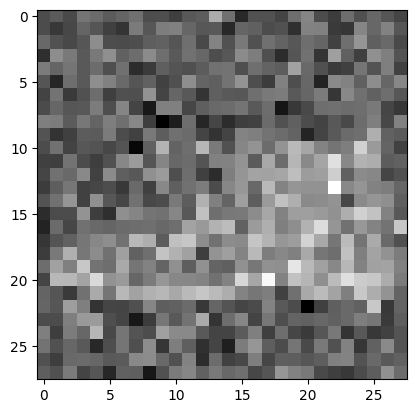

In [82]:
noise_level = 0.3
f_mnist_test_with_noise = inject_noise(testset.data, noise_level)
__ = plt.imshow(f_mnist_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

The `get_accuracy_values_at_noise_level` function computes the accuracy values of the models at a specified noise level. Here's how it works:

- **Input Parameter:**
  - `noise_level`: Magnitude of the noise injected into the test data.

- **Functionality:**
  - Injects noise into the Fashion MNIST test data using the provided noise level.
  - Computes the hidden representations for each layer of the DBN (`hidden_repr_layer_1_noisy`, `hidden_repr_layer_2_noisy`, `hidden_repr_layer_3_noisy`) using the noisy test data.
  - Utilizes the previously trained linear classifiers to make predictions (`predictions_first_hidden_noisy`, `predictions_second_hidden_noisy`, `predictions_third_hidden_noisy`) based on the noisy representations.
  - Calculates the accuracy of the predictions made by each linear classifier (`accuracy_first_hidden`, `accuracy_second_hidden`, `accuracy_third_hidden`) using the noisy test data.
  - Computes the predictions of the feed-forward neural network (`ffnn`) on the noisy test data and calculates its accuracy (`accuracy_ffnn`).

The function returns the accuracy values for the linear classifiers at each layer of the DBN and the feed-forward neural network at the specified noise level.


In [83]:
def get_accuracy_values_at_noise_level(noise_level):

  f_mnist_test_with_noise = inject_noise(testset.data, noise_level)  # first, let's create noisy test images
  
  hidden_repr_layer_1_noisy = get_kth_layer_repr(f_mnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, testset.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, testset.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, testset.targets)
  
  predictions_ffnn_noisy = ffnn(f_mnist_test_with_noise.reshape((10000, 784)))  # we repeat a similar process for the feed-forward model
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy, testset.targets)

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [84]:
acc = get_accuracy_values_at_noise_level(0.3);
print("Accuracy of H1 read-out: %.3f" % acc[0])
print("Accuracy of H2 read-out: %.3f" % acc[1])
print("Accuracy of H3 read-out: %.3f" % acc[2])
print("Accuracy of FF network : %.3f" % acc[3])

Accuracy of H1 read-out: 0.814
Accuracy of H2 read-out: 0.827
Accuracy of H3 read-out: 0.828
Accuracy of FF network : 0.791


The `plot_noise_robustness_curves` function generates plots illustrating the robustness of the models to different noise levels. Here's how it works:

- **Input Parameter:**
  - `noise_levels`: List of noise levels to be evaluated.

- **Functionality:**
  - Initializes empty lists to store the accuracy values for each model at each noise level.
  - Iterates over each noise level in the provided list.
  - Calls the `get_accuracy_values_at_noise_level` function to obtain the accuracy values for each model at the current noise level.
  - Appends the accuracy values to the corresponding lists.
  - Plots the accuracy values for each model against the noise levels using Matplotlib.
  - Sets the title, labels for the x and y axes, and the legend.
  - Converts the noise levels from decimal to percentage format for better readability on the x-axis.

This function visualizes the noise robustness of the models, showing how their accuracy changes as the noise level increases.

In [85]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

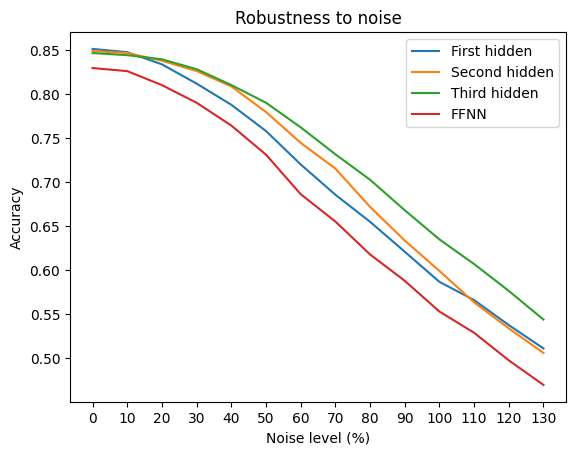

In [86]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

## Perturbing the models with adversarial attacks

### Fast gradient sign method

Reference: https://jaketae.github.io/study/fgsm/

In adversarial attacks, the objective is to modify the input so that the model fails to correctly classify it, resulting in an increased loss for that specific input. Typically denoted as $J(w, x, y)$.

During model training, adjustments to the model's weights are made based on the gradient of the loss function. This adjustment is made in the opposite direction of the gradient to minimize the loss. However, in crafting an adversarial sample, two alterations are made:

1. Instead of modifying the model's weights, the input is altered.
2. The alteration aligns with the direction of the gradient, aiming to increase the loss function.

The adversarial sample is represented as:

$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_{x} J(w, x, y))$

The `fgsm_attack` function implements the Fast Gradient Sign Method (FGSM) for crafting adversarial examples. Here's a breakdown of its logic:

1. **Input Parameters:**
   - `image`: The original input image.
   - `epsilon`: The magnitude of the perturbation applied to the image.
   - `data_grad`: The gradient of the loss function with respect to the input image.

2. **Functionality:**
   - Computes the element-wise sign of the data gradient to determine the direction of perturbation.
   - Adjusts each pixel of the input image by adding or subtracting \( \epsilon \) times the sign of the data gradient.
   - Clips the perturbed image to ensure its pixel values remain within the [0, 1] range.
   - Returns the perturbed image as the output.

This function is a key component in generating adversarial examples by perturbing input images in a manner that maximizes the loss function, leading to misclassification by the model.


In [87]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

### Adversarial samples

The `DBNWithReadOut` class integrates a Deep Belief Network (DBN) with linear readouts for classification. Here's a summary of its logic:

1. **Initialization:**
   - It takes a pre-trained DBN (`dbn_f_mnist`), a list of linear readout models (`readouts`), and an optional `readout_level` parameter.
   - The DBN's parameters are set to require gradients for further training.

2. **Forward Pass:**
   - The `forward` method takes an input image and passes it through each layer of the DBN.
   - During the forward pass, the RBM outputs probabilities instead of samples to enable gradient backpropagation.
   - Hidden states are collected at each layer and passed to the corresponding linear readout model specified by the `readout_level`.
   - The output of the selected readout model is returned.

This class allows for end-to-end training of the DBN with linear readouts, facilitating classification tasks while leveraging the hierarchical features learned by the DBN.


In [91]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_f_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_f_mnist = dbn_f_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_f_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_f_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [92]:
dbn_with_readout = DBNWithReadOut(dbn_f_mnist, [linear1, linear2, linear3], readout_level=2)

This code selects a sample from the test set (`testset.data`) at index `test_sample_idx`. It then reshapes the image to have a single channel and a size of 28x28 pixels (the same size as the Fashion MNIST images). Finally, it displays the reshaped image using Matplotlib's `imshow` function.

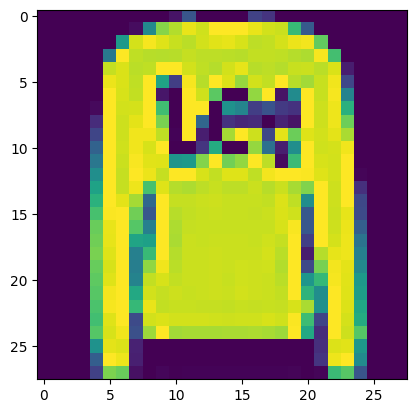

In [93]:
test_sample_idx = 1
test_image = testset.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'))

Here, we initialize `attacked_model` to either the feedforward neural network (`ffnn`) or the DBN with linear readouts (`dbn_with_readout`). Then, we set `test_image` to require gradients for adversarial attack. 

Next, we compute the output of the model for the test image and calculate the prediction by selecting the index of the maximum output. Finally, we print the prediction of the model for the clean sample.


In [94]:
attacked_model = ffnn

In [95]:
attacked_model = dbn_with_readout

In [96]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {prediction}.")

The prediction of the model for this clean sample is 2.


We perform a Fast Gradient Sign Method (FGSM) attack on the input image to generate a perturbed image. Here's a summary of the logic:

1. `epsilon` is defined as the strength of the attack.
2. The ground truth label for the test image (`test_image_label`) is obtained.
3. The loss value is computed using the model's outputs and the ground truth label.
4. The gradients of the pixels with respect to the loss are computed.
5. The perturbed image is generated using the FGSM attack by adjusting each pixel of the input image based on the sign of the computed gradients and the defined epsilon.
6. Finally, the perturbed image is displayed using Matplotlib's `imshow` function.


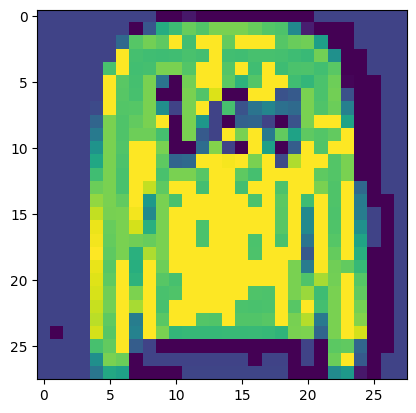

In [97]:
epsilon = 0.2  # define strenght of the attack
test_image_label = testset.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28,28))

In [98]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}.")

The prediction of the model for the perturbed sample is 8.


### Assessing Adversarial Robustness

Next, we'll evaluate the resilience of our two models, the feedforward network and the DBN, against adversarial attacks. Additionally, we'll examine whether the DBN can mitigate the attack's impact by conducting one "top-down" reconstruction step, transitioning from the hidden representation of the last layer to the visible units and back to the hidden representation.

We define a function `test_robustness_to_attack` to evaluate the robustness of a model against adversarial attacks. Here's a breakdown:

1. **Iterating through Test Data**: The function iterates through the test dataset using a provided data loader.
2. **Preparing Data**: It moves data and target labels to the specified device (GPU or CPU) and reshapes the data into a flattened format.
3. **Forward Pass**: It performs a forward pass through the model to obtain the model's output predictions.
4. **Calculating Loss**: The loss between the model's output and the target labels is calculated.
5. **Backward Pass**: Backpropagation is performed to compute gradients of the loss with respect to the input data.
6. **Adversarial Perturbation**: The `fgsm_attack` function is used to generate perturbed data by adding noise to the input data based on the computed gradients.
7. **Reconstruction (Optional)**: If requested, the perturbed data can be reconstructed using a specified number of forward-backward iterations through the DBN.
8. **Re-classification**: The perturbed data is fed back into the model for re-classification.
9. **Accuracy Calculation**: The accuracy of the model on the perturbed data is calculated by comparing the model's predictions with the target labels.
10. **Print Results**: It prints the epsilon value (strength of the attack) and the test accuracy.

This function allows for testing the model's performance under adversarial conditions and can be used to assess its robustness.


In [111]:
from tqdm.notebook import tqdm
import torch.nn.functional as functional

def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack
        
        output = model.forward(data)

        init_pred = torch.argmax(output)
        
        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_f_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [112]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

Let's see how good the FFNN does:

In [113]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 26.96%



we compare compare with the read-out trained on the hidden representations of the DBN:

In [114]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1, 
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 40.84%



And finally let's test whether using one step of top-down reconstruction from the generative model allows to improve resilience to attacks:

  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



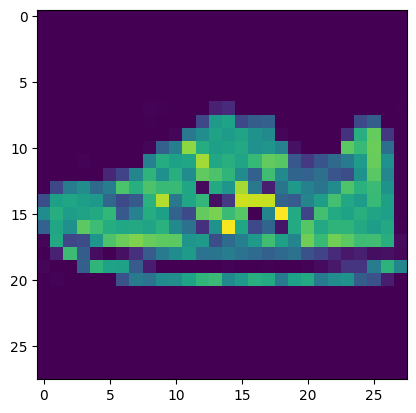


Here's a perturbed sample:



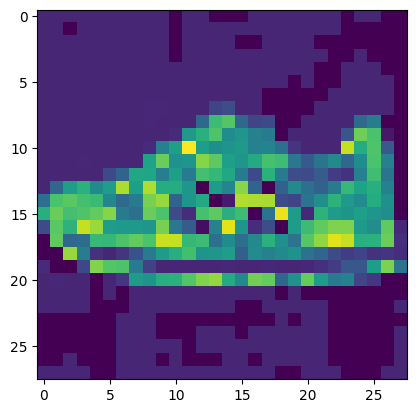


Here's what a 1-steps reconstructed sample looks like:



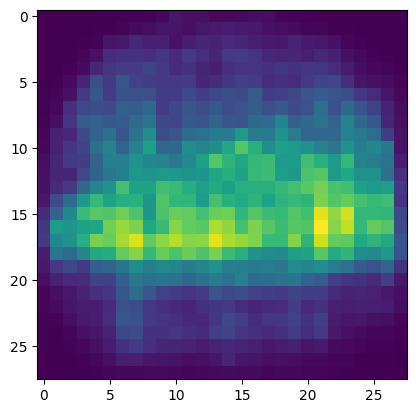


Epsilon: 0.1
Test Accuracy: 36.66%



In [115]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Impact of the noise parameter $\epsilon$

Now, we'll assess how each model's robustness varies against adversarial attacks of varying "intensities":

We define a function `test_epsilon_values_effect` that evaluates the impact of different epsilon values (strengths of adversarial attacks) on a given model. It iterates through a list of epsilon values and calls the `test_robustness_to_attack` function for each epsilon value, passing the model, device, test loader, epsilon value, number of steps for reconstruction, and setting verbose to False. The function then collects the accuracies for each epsilon value and returns them. This allows for an assessment of the model's robustness against adversarial attacks of varying strengths.


In [116]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

Here we evaluate the impact of different epsilon values (strengths of adversarial attacks) on three different models: `ffnn`, `dbn_with_readout` with 0 reconstruction steps (`n_steps=0`), and `dbn_with_readout` with 1 reconstruction step (`n_steps=1`). We call the `test_epsilon_values_effect` function for each model with the specified number of reconstruction steps, collecting the accuracies for each epsilon value. By comparing the accuracies across models and reconstruction steps, the code helps assess the robustness of each model to adversarial attacks under different conditions.


In [117]:
%%capture
accuracies_ffnn = test_epsilon_values_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

Let's plot the results:

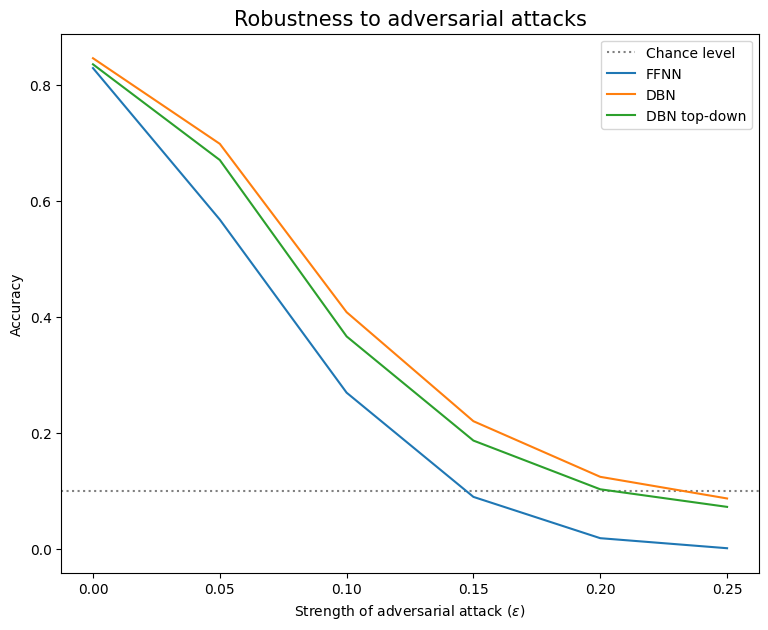

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level", "FFNN", "DBN", "DBN top-down"])